Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,psq.king_end.56,psq.king_end.57,psq.king_end.58,psq.king_end.59,psq.king_end.60,psq.king_end.61,psq.king_end.62,psq.king_end.63,queen_near_to_king,two_bishops
0,1.0,1,132,126,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,132,123,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,132,120,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,132,119,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,132,114,0,0,0,0,0,0,...,0,0,0,0,107,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202236,0.0,30000,99,5,-512,0,0,-256,0,0,...,0,0,0,0,0,0,0,0,0,0
2202237,0.0,30000,99,3,-512,0,0,-256,-256,0,...,0,0,0,0,0,0,0,0,0,0
2202238,0.0,30000,99,2,-512,0,0,-256,-256,0,...,0,0,0,0,0,0,0,0,0,0
2202239,0.0,30000,99,1,-512,0,0,-256,-256,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [5]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [6]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [7]:
del data
del dv

In [8]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [51]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [52]:
opt = torch.optim.Adam(model.parameters(), lr=5e-5)

Определяем функцию потерь:

In [53]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 1)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [54]:
C = 0.004

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 8000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.4304, test_loss = 0.3772
step #100, train_loss = 0.3994, test_loss = 0.3426
step #200, train_loss = 0.3679, test_loss = 0.3127
step #300, train_loss = 0.3416, test_loss = 0.2855
step #400, train_loss = 0.3147, test_loss = 0.2604
step #500, train_loss = 0.2907, test_loss = 0.2396
step #600, train_loss = 0.2695, test_loss = 0.2225
step #700, train_loss = 0.2506, test_loss = 0.2074
step #800, train_loss = 0.2362, test_loss = 0.1961
step #900, train_loss = 0.2242, test_loss = 0.1877
step #1000, train_loss = 0.2137, test_loss = 0.1807
step #1100, train_loss = 0.2066, test_loss = 0.1747
step #1200, train_loss = 0.1979, test_loss = 0.1689
step #1300, train_loss = 0.1908, test_loss = 0.1634
step #1400, train_loss = 0.1826, test_loss = 0.1578
step #1500, train_loss = 0.1775, test_loss = 0.1519
step #1600, train_loss = 0.1680, test_loss = 0.1464
step #1700, train_loss = 0.1616, test_loss = 0.1410
step #1800, train_loss = 0.1539, test_loss = 0.1343
step #1900, train_loss =

KeyboardInterrupt: 

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [55]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.070189826

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [56]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.8126, 0.8394, 0.8268, 0.8466, 0.8542, 0.8475, 0.8488, 0.8739, 0.8679,
        0.8576, 0.8606, 0.8527, 0.8629, 0.8668, 0.8587, 0.8816, 0.9693, 0.9751,
        0.9819, 0.9768], grad_fn=<SliceBackward>) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [57]:
ws = (model.linear.weight[0]).detach().numpy()
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[ 100    0  247  265  419  782    0    0    0    0    0    0    0   -1
  137  137  136  114  124  156  118  136   65   77   69   63   55   46
   78   56   16    8    7    1    3    3    3    0    0    0   -8   -2
   -1  -11   -8  -13   -1   -3  -10  -10  -15   -9    0   -9  -17  -16
  -16  -22  -24   -9   -2  -22    0    0    0    0    1    0    0    0
    0    0    0    0    0    0    1    0    0   -4    0    0    0    0
    4   -1    0    0   -1    0    0    6   -1   -1    1    0    7    1
    2    0   -2    0    0   -1    1    1    0  -10   -4  -12   -8    1
    0   -1   -3   -6    1   -2    7   -2   22  -31  -12   -4   31   49
    2   69   33  -54   27   -5   68   83  -83   -2   -7   13   -1    1
   -1   -5  -56  -21   -1   29    7    0   -1   -2   -1    9   32   35
   37   39    8    2    2    5    1   31   42   34   21   39  -22    2
   17    0   31   -2   12   -7  -35  -40    1   20   21    9   21  -12
  -18  -26    2  -23   -8   -2   -4    1  -14  -49  -41  -10    0   -7
  -44 

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [67]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [68]:
ww[:6]

array([100,   0, 247, 265, 419, 782], dtype=int32)

Таблицы фигура-поле для пешки:

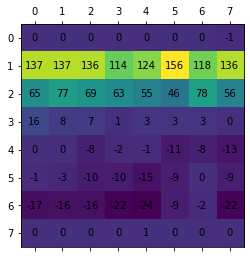

In [69]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

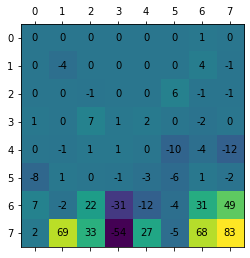

In [70]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

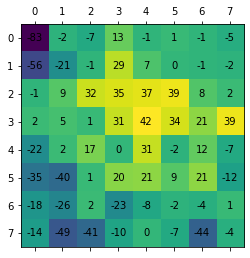

In [71]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

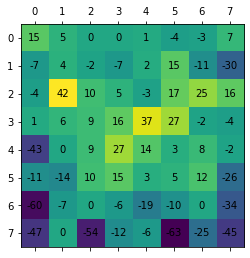

In [72]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

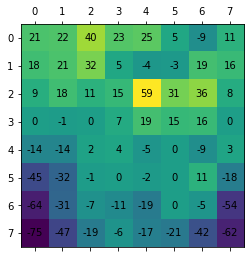

In [74]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

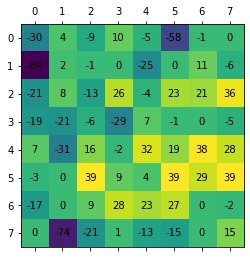

In [75]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

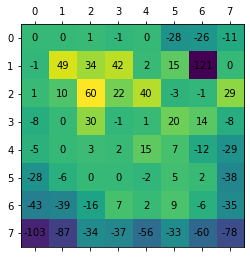

In [76]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость ферзя, близкого к вражескому королю, и стоимость двух слонов:

In [77]:
ww[-2], ww[-1]

(62, 23)